In [12]:
!pip install alpaca-trade-api

6800.23s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


In [13]:
!pip install yfinance

6811.46s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


In [30]:
def signal_generator(df):
    buy_signals = []
    sell_signals = []
    for i in range(1, len(df)):
        if df['SMA10'].iloc[i] > df['SMA20'].iloc[i] and df['SMA10'].iloc[i-1] < df['SMA20'].iloc[i-1]:
            buy_signals.append(df['Close'].iloc[i])
            sell_signals.append(np.nan)
        elif df['SMA10'].iloc[i] < df['SMA20'].iloc[i] and df['SMA10'].iloc[i-1] > df['SMA20'].iloc[i-1]:
            buy_signals.append(np.nan)
            sell_signals.append(df['Close'].iloc[i])
        else:
            buy_signals.append(np.nan)
            sell_signals.append(np.nan)
    return buy_signals, sell_signals

In [15]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import alpaca_trade_api as tradeapi

In [20]:
restaurant_tickers = ['MCD', 'YUM', 'CMG', 'SBUX', 'QSR', 'DPZ', 'DRI', 'YUMC', 'WEN', 'TXRH']
restaurant_tickers = [x.lower() for x in restaurant_tickers]
dataframes = {}
end = datetime.now()
start = datetime(end.year - 1, end.month, end.day)
for ticker in restaurant_tickers:
    dataframes[ticker] = yf.download(ticker, start=start, end=end)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


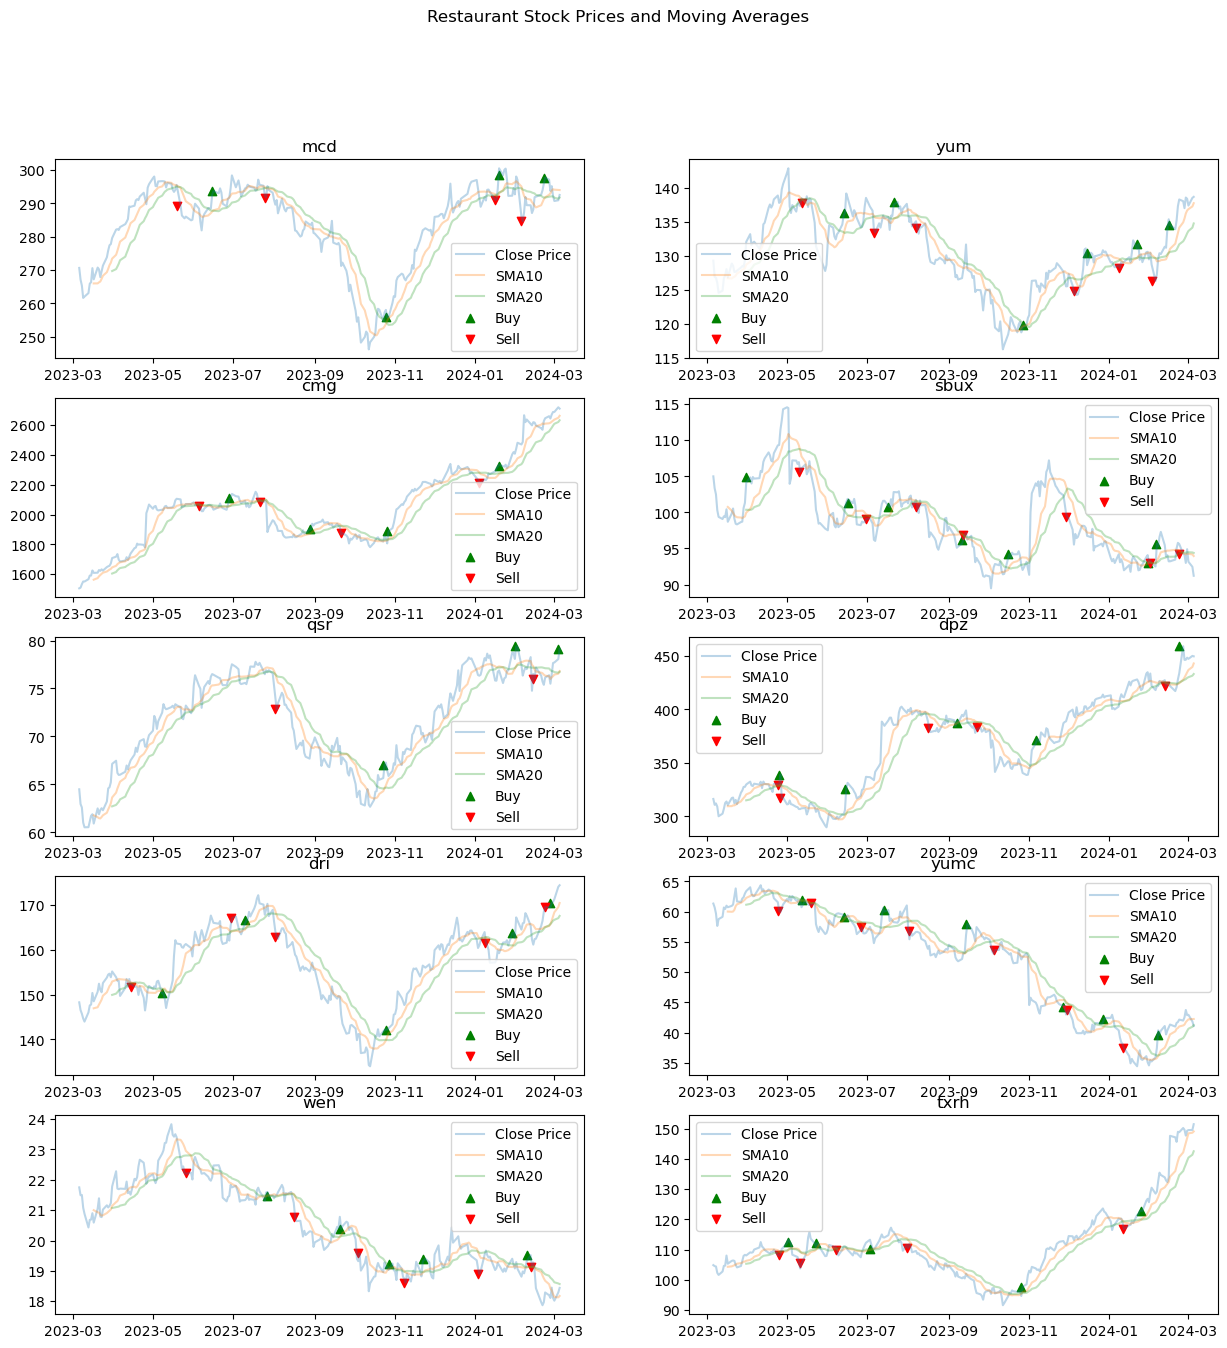

In [31]:
for ticker in restaurant_tickers:
    dataframes[ticker]['SMA10'] = dataframes[ticker]['Close'].rolling(window=10).mean()
    dataframes[ticker]['SMA20'] = dataframes[ticker]['Close'].rolling(window=20).mean()
    #pad the shorter signal with nan
    dataframes[ticker]['Buy'] = signal_generator(dataframes[ticker])[0] + [np.nan]*(len(dataframes[ticker])-len(signal_generator(dataframes[ticker])[0]))
    dataframes[ticker]['Sell'] = signal_generator(dataframes[ticker])[1] + [np.nan]*(len(dataframes[ticker])-len(signal_generator(dataframes[ticker])[1]))


fig, axs = plt.subplots(5, 2, figsize=(15, 15))
fig.suptitle('Restaurant Stock Prices and Moving Averages')
for i in range(5):
    for j in range(2):
        ticker = restaurant_tickers[i*2+j]
        axs[i, j].plot(dataframes[ticker].index, dataframes[ticker]['Close'], label='Close Price', alpha=0.3)
        axs[i, j].plot(dataframes[ticker].index, dataframes[ticker]['SMA10'], label='SMA10', alpha=0.3)
        axs[i, j].plot(dataframes[ticker].index, dataframes[ticker]['SMA20'], label='SMA20', alpha=0.3)
        axs[i, j].scatter(dataframes[ticker].index, dataframes[ticker]['Buy'], label='Buy', marker='^', color='g')
        axs[i, j].scatter(dataframes[ticker].index, dataframes[ticker]['Sell'], label='Sell', marker='v', color='r')
        axs[i, j].set_title(ticker)
        axs[i, j].legend()

In [55]:
#backtest
#initialize variables
initial_capital = 100000
positions = {}
for ticker in restaurant_tickers:
    positions[ticker] = 0
for ticker in restaurant_tickers:
    for i in range(1, len(dataframes[ticker])):
        if dataframes[ticker]['Buy'].iloc[i] > 0:
            positions[ticker] = initial_capital // dataframes[ticker]['Close'].iloc[i]
            initial_capital -= positions[ticker] * dataframes[ticker]['Close'].iloc[i]
        elif dataframes[ticker]['Sell'].iloc[i] > 0:
            initial_capital += positions[ticker] * dataframes[ticker]['Close'].iloc[i]
            positions[ticker] = 0

finalCapital = initial_capital + sum([positions[ticker] * dataframes[ticker]['Close'].iloc[-1] for ticker in restaurant_tickers])

print('Backtest Results')
print('Initial Capital:', 100000)
print('Final Capital:', finalCapital)
print('Return:', (finalCapital-100000)/100000)
print('total number of trades:', sum([len(dataframes[ticker][dataframes[ticker]['Buy'] > 0]) + len(dataframes[ticker][dataframes[ticker]['Sell'] > 0]) for ticker in restaurant_tickers]))
print("number trades per ticker:", [len(dataframes[ticker][dataframes[ticker]['Buy'] > 0]) + len(dataframes[ticker][dataframes[ticker]['Sell'] > 0]) for ticker in restaurant_tickers])
print("average mcd buy price:", dataframes['mcd'][dataframes['mcd']['Buy'] > 0]['Close'].mean())
print("average mcd sell price:", dataframes['mcd'][dataframes['mcd']['Sell'] > 0]['Close'].mean())
print("mcd price change:", dataframes['mcd']['Close'].iloc[-1] - dataframes['mcd']['Close'].iloc[0])
print("growth rate of restaurant tickers over time period")
print("average sbux buy price:", dataframes['sbux'][dataframes['sbux']['Buy'] > 0]['Close'].mean())
print("average sbux sell price:", dataframes['sbux'][dataframes['sbux']['Sell'] > 0]['Close'].mean())
print("sbux price change:", dataframes['sbux']['Close'].iloc[-1] - dataframes['sbux']['Close'].iloc[0])
for ticker in restaurant_tickers:
    print(ticker, (dataframes[ticker]['Close'].iloc[-1]-dataframes[ticker]['Close'].iloc[0])/dataframes[ticker]['Close'].iloc[0])
print("average growth rate of restaurant tickers over time period")
print(sum([(dataframes[ticker]['Close'].iloc[-1]-dataframes[ticker]['Close'].iloc[0])/dataframes[ticker]['Close'].iloc[0] for ticker in restaurant_tickers])/10)


Backtest Results
Initial Capital: 100000
Final Capital: 105909.03818511963
Return: 0.05909038185119629
total number of trades: 102
number trades per ticker: [8, 12, 8, 14, 5, 10, 10, 14, 11, 10]
average mcd buy price: 286.77249908447266
average mcd sell price: 291.24249267578125
mcd price change: 21.899993896484375
growth rate of restaurant tickers over time period
average sbux buy price: 97.54857199532645
average sbux sell price: 98.97857121058873
sbux price change: -13.769996643066406
mcd 0.08091927546239812
yum 0.0726991003451224
cmg 0.8013926168032911
sbux -0.13115531882316786
qsr 0.22701193789111887
dpz 0.42131381489591974
dri 0.17629998405890362
yumc -0.3296918411384206
wen -0.1521838834916038
txrh 0.44526036782034034
average growth rate of restaurant tickers over time period
0.1611866053823902


In [64]:

# Replace these with your Alpaca account API key and secret
API_KEY = 'PK2XQJA09KCRSN2HSWZ9'
API_SECRET = 'qCCVn3tp0iiN6u5E2hN9uS586xRSBmPMvAPhchX8'
BASE_URL = 'https://paper-api.alpaca.markets'  # Use the paper trading environment

# Initialize the Alpaca API
api = tradeapi.REST(API_KEY, API_SECRET, BASE_URL, api_version='v2')

# Check your account information
account = api.get_account()
print(account)

'''# Define the order parameters
symbol = 'MCD'  # Symbol for Apple Inc.
qty = 1  # Number of shares
side = 'buy'  # 'buy' or 'sell'
order_type = 'market'  # 'market' or 'limit'
time_in_force = 'gtc'  # 'gtc' (good till canceled), 'ioc' (immediate or cancel), etc.

# Place the order
order = api.submit_order(
    symbol=symbol,
    qty=qty,
    side=side,
    type=order_type,
    time_in_force=time_in_force
)

print(order)'''

#trade according to live signals
def live_signal_generator(df):
    if df['SMA10'].iloc[-1] > df['SMA20'].iloc[-1] and df['SMA10'].iloc[-2] < df['SMA20'].iloc[-2]:
        return 'buy'
    elif df['SMA10'].iloc[-1] < df['SMA20'].iloc[-1] and df['SMA10'].iloc[-2] > df['SMA20'].iloc[-2]:
        return 'sell'
    else:
        return 'hold'
    
liveDataframes = {}
end = datetime.now()
start = datetime(end.year, end.month - 2, end.day)
for ticker in restaurant_tickers:
    liveDataframes[ticker] = yf.download(ticker, start=start, end=end)
    liveDataframes[ticker]['SMA10'] = liveDataframes[ticker]['Close'].rolling(window=10).mean()
    liveDataframes[ticker]['SMA20'] = liveDataframes[ticker]['Close'].rolling(window=20).mean()
    print(ticker, liveDataframes[ticker]['Close'].iloc[-1], liveDataframes[ticker]['SMA10'].iloc[-1], liveDataframes[ticker]['SMA20'].iloc[-1])
    liveDataframes[ticker]['Signal'] = live_signal_generator(liveDataframes[ticker])

for ticker in restaurant_tickers:
    if liveDataframes[ticker]['Signal'].iloc[-1] == 'buy':
        order = api.submit_order(
            symbol=ticker,
            qty=1,
            side='buy',
            type='market',
            time_in_force='gtc'
        )
        print("buying ", ticker)
    elif liveDataframes[ticker]['Signal'].iloc[-1] == 'sell':
        order = api.submit_order(
            symbol=ticker,
            qty=1,
            side='sell',
            type='market',
            time_in_force='gtc'
        )
        print("selling ", ticker)
    print(order)



Account({   'account_blocked': False,
    'account_number': 'PA3T240TC7LB',
    'accrued_fees': '0',
    'admin_configurations': {},
    'balance_asof': '2024-03-05',
    'bod_dtbp': '0',
    'buying_power': '199119.66',
    'cash': '99117.27',
    'created_at': '2024-03-06T13:02:48.659849Z',
    'crypto_status': 'ACTIVE',
    'crypto_tier': 0,
    'currency': 'USD',
    'daytrade_count': 1,
    'daytrading_buying_power': '0',
    'effective_buying_power': '199119.66',
    'equity': '100002.39',
    'id': 'b136fe5b-c6e8-410d-83c1-903cc51db31a',
    'initial_margin': '442.56',
    'last_equity': '100000',
    'last_maintenance_margin': '0',
    'long_market_value': '885.12',
    'maintenance_margin': '265.54',
    'multiplier': '2',
    'non_marginable_buying_power': '99117.27',
    'pattern_day_trader': False,
    'pending_transfer_in': '0',
    'portfolio_value': '100002.39',
    'position_market_value': '885.12',
    'regt_buying_power': '199119.66',
    'short_market_value': '0',
  

[*********************100%%**********************]  1 of 1 completed


mcd 295.010009765625 294.12400512695314 292.2565002441406


[*********************100%%**********************]  1 of 1 completed


yum 139.50999450683594 138.19499969482422 135.39849929809571


[*********************100%%**********************]  1 of 1 completed

cmg 2682.530029296875 2674.3210205078126 2643.1349975585936



[*********************100%%**********************]  1 of 1 completed

sbux 91.57250213623047 93.61225051879883 94.18262519836426



[*********************100%%**********************]  1 of 1 completed


qsr 80.78500366210938 77.31949920654297 76.95324897766113


[*********************100%%**********************]  1 of 1 completed

dpz 448.05499267578125 445.65149841308596 434.3942504882813



[*********************100%%**********************]  1 of 1 completed

dri 174.3800048828125 171.23399963378907 167.97999954223633



[*********************100%%**********************]  1 of 1 completed


yumc 42.68000030517578 42.366999816894534 41.5004997253418


[*********************100%%**********************]  1 of 1 completed

wen 18.510000228881836 18.239000511169433 18.54450035095215



[*********************100%%**********************]  1 of 1 completed

txrh 151.0500030517578 149.68799896240233 143.67049865722657
Order({   'asset_class': 'us_equity',
    'asset_id': 'e077638f-a5c9-47e4-a7ce-2bfabf5ff698',
    'canceled_at': None,
    'client_order_id': '209de85c-ca4b-4476-8feb-c05066f1251e',
    'created_at': '2024-03-06T15:00:25.925191286Z',
    'expired_at': None,
    'extended_hours': False,
    'failed_at': None,
    'filled_at': None,
    'filled_avg_price': None,
    'filled_qty': '0',
    'hwm': None,
    'id': '534ed73f-b114-49f8-ab96-8eb8c25ecf0c',
    'legs': None,
    'limit_price': None,
    'notional': None,
    'order_class': '',
    'order_type': 'market',
    'qty': '1',
    'replaced_at': None,
    'replaced_by': None,
    'replaces': None,
    'side': 'buy',
    'source': None,
    'status': 'pending_new',
    'stop_price': None,
    'submitted_at': '2024-03-06T15:00:25.924026857Z',
    'subtag': None,
    'symbol': 'MCD',
    'time_in_force': 'gtc',
    'trail_percent': None,
    'trail_price': None,
    'type': 'ma